## Class 08 Agenda:
  * **Null accuracy**
  * **Confusion matrix**
  * **sensitivity, specificity, accuracy**
  * **ROC curves, AUC, setting a threshold**
  * **ROC curves, AUC: All that matters is that ordering is preserved**
  * **Pipelines: Putting your entire ML workflow together**

Today we are going to talk about how to more accurately measure models for supervised classification. Because supervised classification problems are ubiquitous (will this person churn? will this ad be clicked? will this stock go up tomorrow?), being able to evaluate how well a supervised classifier works and to be able to choose what defines a "well-performing" classifier is very important.

To that end, we will also learn how to:
  * decompose the kinds of errors a trained model makes (on unseen data)
  * decide where (at what probability) to threshold a binary classifier (one that decides between two choices) given what is acceptable in terms of the kinds of errors the model is expected to make in the wild. 
  * understand confusion matrices
  
** By the end of this notebook you will:**

- Have a working conceptual understanding of key aspects of model evaluation in machine learning
- Be able to interpret key model metrics computed using scikit-learn
- Be able to to use different model metrics for model evaluation, depending on the goals of your model
- Be able to explain what an ROC curve and AUC metric are and how they should be used when evaluating classifiers and setting classifier thresholds.

Let's import everything we're going to use today, like always:

In [1]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn import metrics
import scipy.stats as stats

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier import ClassBalance
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC

### Null Accuracy

Null accuracy measures what our expected accuracy should be if we were to **use the most frequent response (most frequent class) as our prediction for every new sample we see.** It is a baseline against which you may want to measure your classifier, especially when your classes are really unbalanced.

In class 5, when we learned about [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression), we attempted to build a predictive model on a dataset that was fairly unbalanced (the vertebral column dataset from UCI).

Let's use that dataset again to measure null accuracy, and see whether a basic Logistic Regression model can give higher test set accuracy than this:

In [2]:
vertebral_data = pd.read_csv("data/vertebral_column_2_categories.dat",sep=" ", 
                             names=["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle",
                                    "sacral_slope","pelvic_radius","spondy_grade","outcome"])
vertebral_data.outcome.value_counts()
vertebral_data.outcome = (vertebral_data.outcome =="AB").astype(int)
X = vertebral_data[vertebral_data.columns.tolist()[:-1]]
y = vertebral_data.outcome



In [7]:
# Please complete:

# Use train_test_split with a 70/30 split
X_train, X_test, y_train, y_test = ____________(X, y, test_size=______,random_state=1)

# instantiate a LogisticRegression object
lr = _________________
# fit the lr model on the training set
lr._______(_______,_______)
# predict on the test set
y_test_pred = lr._______(_______)

# return the accuracy of the model
print("Test set accuracy of LR model: ",metrics.accuracy_score(_______, _______))

NameError: name '____________' is not defined

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

lr = LogisticRegression(C=1e9)
lr.fit(X_train,y_train)
y_test_pred = lr.predict(X_test)

print("Test set accuracy of LR model: ",metrics.accuracy_score(y_test, y_test_pred))

Test set accuracy of LR model:  0.8709677419354839


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**What is the null accuracy here?**

It is simply the fraction of `AB` (class 1) samples in the test set (since that is the most frequent class in the whole dataset):

In [5]:
# compute null accuracy manually
print("Null accuracy on the test set: ",y_test.mean())

Null accuracy on the test set:  0.7096774193548387


We can compute this using the scikit-learn api by creating what's called a `DummyClassifier`.

It can create a variety of dummy models based on simple statistics it is trained on.

We are going to create one where the model simply predicts the most frequent class, by passing in a `string` to the `strategy` parameter when we generate the unfitted model: 

In [6]:
from sklearn.dummy import DummyClassifier
# The dummy classifier gives you a measure of “baseline” performance 
#  — i.e. the success rate one should expect to achieve even if simply guessing.

dumb_model = DummyClassifier(strategy='most_frequent') #most_frequent always predicts the most frequent label in the training set.
# fit the DummyClassifier object on training set
dumb_model.fit(X_train, y_train)
# predict on test set
y_dumb_class = dumb_model.predict(X_test)
# return accuracy score of actuals vs predicted
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))

Most frequent class dummy classifier test accuracy:  0.7096774193548387


### Class Balance in Yellowbrick

Class balance is a chart that shows the support for each class in the fitted classification model displayed as a bar plot. 
It is initialized with a fitted model and generates a class balance chart on draw.

http://www.scikit-yb.org/en/latest/api/classifier/class_balance.html

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


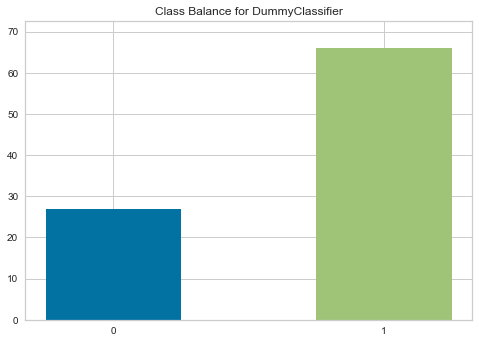

In [7]:

visualizer = ClassBalance(dumb_model, classes=[0,1])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof() 

### LearningCurve

A learning curve shows the relationship of the training score vs the cross validated test score for an estimator with a varying number of training samples.
This visualization is typically used two show two things:

1.How much the estimator benefits from more data (e.g. do we have “enough data” or will the estimator get better if used in an online fashion).

2.If the estimator is more sensitive to error due to variance vs. error due to bias.

http://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


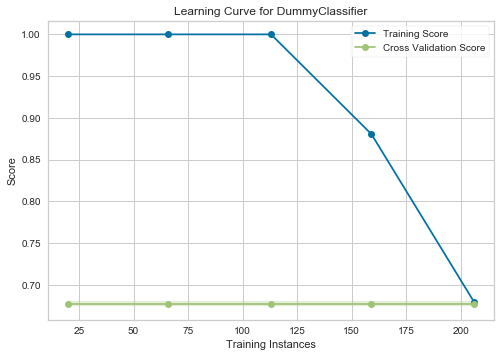

In [8]:
viz = LearningCurve(DummyClassifier(strategy='most_frequent'))
viz.fit(X,y)
viz.poof()

### Confusion Matrix

In order to more fully understand the kinds of mistakes the model is making, we need to investigate what is called the **confusion matrix** of the model on unseen (test) data. The confusion matrix simply counts the number of predictions that fall into each possible prediction bucket.

So, for a 2-class classification problem, there are 4 "prediction buckets":
  * predict 0 (normal), actual 0 (normal) - called a **correct rejection/true negative**
  * predict 0 (normal), actual 1 (abnormal) <-- this is an error called a **miss/false negative**
  * predict 1 (abnormal), actual 0 (normal) <-- this is an error called a **false alarm/false positive**
  * predict 1 (abnormal), actual 1 (abnormal) - called a **hit/true positive**
  
![confusion matrix](./images/confusion_matrix.png)

Let's compute the confusion matrix on the test set for our Logistic Regression model:

In [9]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_pred)
cm

array([[21,  6],
       [ 6, 60]], dtype=int64)

By convention in a confusion matrix, the actual categories are the rows and the predicted values are the columns. Our confusion matrix shows that on the test set we have an equal number of misses and false alarms (both values are 6).

We can break down the confusion matrix into a variety of single-value metrics that answer specific questions about how our model is expected to fare on new data:

  * **sensitivity/true positive rate(TPR)/recall:** What fraction of the "abnormal" samples in unseen data did we correctly predict? 
  $$ TPR = \frac {\sum TP}{\sum (TP+FN)}$$
  * **specificity/true negative rate(TNR):** What fraction of "normal" samples in unseen data did we correctly predict?  
  $$ TNR = \frac {\sum TN}{\sum (TN+FP)}$$
  * **precision/positive predictive value(PPV)** How frequently is our model correct when it predicts "abnormal" on new data?
  $$ PPV = \frac {\sum TP}{\sum (TP+FP)}$$
  * **negative predictive value (NPV):** How frequently is our model correct when it predicts "normal" on new data? 
  $$ NPV = \frac {\sum TN}{\sum (TN+FN)}$$
  * **accuracy (ACC):** How frequently is our model correct on all new data, regardless of class?
  $$ ACC = \frac {\sum (TN+TP)}{\sum (TN+FN+TP+FP)}$$
  * **F1 score (F1): ** The harmonic mean of precision and recall:
  $$ F1 = 2*\frac {Precision*Recall}{Precision+Recall}$$

In [10]:
# calculate each metric by hand
print("Sensitivity/Recall (TPR): ",cm[1,1] / float(cm[1,1] + cm[1,0]))
print("Specificity (TNR): ", cm[0,0] / float(cm[0,0] + cm[0,1]))
print("Precision (PPV): ", cm[1,1] / float(cm[1,1]+cm[0,1]))
print("NPV: ", cm[0,0] / float(cm[0,0]+cm[1,0]))
print("Accuracy: ", (cm[1,1]+cm[0,0]) / float(cm.sum()))
print("F1:", metrics.f1_score(y_test,y_test_pred))

Sensitivity/Recall (TPR):  0.9090909090909091
Specificity (TNR):  0.7777777777777778
Precision (PPV):  0.9090909090909091
NPV:  0.7777777777777778
Accuracy:  0.8709677419354839
F1: 0.9090909090909091


In [11]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_test,y_test_pred))
print("Precision (PPV): ", metrics.precision_score(y_test,y_test_pred))
print("Accuracy: ", metrics.accuracy_score(y_test,y_test_pred))
print("F1:", metrics.f1_score(y_test,y_test_pred))


Sensitivity/Recall (TPR):  0.9090909090909091
Precision (PPV):  0.9090909090909091
Accuracy:  0.8709677419354839
F1: 0.9090909090909091


Or we can compute the full classification report, which will give us precision/recall per-feature:

In [12]:
print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78        27
           1       0.91      0.91      0.91        66

   micro avg       0.87      0.87      0.87        93
   macro avg       0.84      0.84      0.84        93
weighted avg       0.87      0.87      0.87        93



### ROC Curves and AUC

So far, we've working with the thresholded decisions a given classifier/model makes when it outputs a prediction (all we've been looking at is the predicted category of trained models). 

However, many classifiers (including both **logistic regression** and **random forest** models) can output a "confidence" associated with their prediction (this is called a **prediction probability**). 

Let's take a look at the prediction probabilites and the predictions of our original logistic regression classifier on our single test set:

In [13]:
#lr probabilities per category for first five samples
predicted_probs_lr = lr.predict_proba(X_test).round(3)
# returns the class predictions (1s or 0s)
predictions_lr = lr.predict(X_test)

print("Logistic Regression predicted probabilities for first five samples in test set:\n",predicted_probs_lr[:5])
print("Logistic Regression predictions for first five samples in test set:\n",predictions_lr[:5])
y_test_lr_df = pd.DataFrame(
    np.concatenate((
        predicted_probs_lr,predictions_lr.reshape((predictions_lr.shape[0],-1)),
        y_test.values.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

y_test_lr_df.head()

Logistic Regression predicted probabilities for first five samples in test set:
 [[0.018 0.982]
 [0.111 0.889]
 [0.011 0.989]
 [0.094 0.906]
 [0.01  0.99 ]]
Logistic Regression predictions for first five samples in test set:
 [1 1 1 1 1]


,class_0,class_1,predicted,actual
0,0.018,0.982,1.0,1.0
1,0.111,0.889,1.0,0.0
2,0.011,0.989,1.0,1.0
3,0.094,0.906,1.0,1.0
4,0.010,0.990,1.0,1.0


Lets generate the same table of predicted probabilities, predictions, and actual values, for a trained random forest classifier that contains 100 trees:

In [60]:
# Please complete
rf = _______________(_______________=100)
# fit on the training data
rf._______(_________,___________)

# store the predicted probabilities
predicted_probs_rf = rf._______(X_test)
# store the predictions
predictions_rf = rf._______(X_test)



,class_0,class_1,predicted,actual
0,0.06,0.94,1.0,1.0
1,0.31,0.69,1.0,0.0
2,0.05,0.95,1.0,1.0
3,0.05,0.95,1.0,1.0
4,0.26,0.74,1.0,1.0


In [14]:
# Completed code
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

predicted_probs_rf = rf.predict_proba(X_test)
predictions_rf = rf.predict(X_test)

In [15]:
# concatenate
y_test_rf_df = pd.DataFrame(
    np.concatenate((
        predicted_probs_rf,predictions_rf.reshape((predictions_rf.shape[0],-1)),
        y_test.values.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

y_test_rf_df.head()

,class_0,class_1,predicted,actual
0,0.04,0.96,1.0,1.0
1,0.32,0.68,1.0,0.0
2,0.06,0.94,1.0,1.0
3,0.04,0.96,1.0,1.0
4,0.25,0.75,1.0,1.0


In both of these cases, the prediction threshold (for either class) is set to 0.5, so the class with the probability that is over 0.5 is the predicted class.

**However, 0.5 doesn't necessarily have to be the threshold we use for our classifier's decision threshold!**

For example, we might want to be VERY CERTAIN that the classifier thinks something is class 1 (for example, a likelihood of cancer presence given some test results). 

In that case, we would require that the class 1 probability is > 0.8 (for example). As a result, the ratio of TP/TN/FN/FP would change, yielding a new confusion matrix, with a new set of precision/recall/accuracy estimates.

**In general, the default probability threshold for a given classifier maximizes accuracy, but not the other metrics like precision, recall, etc.**

But, what if we varied the prediction thresholds to obtain different TP/TN/FP/FN values (different confusion matrices) across all possible threshold values for our classifier?

This is exactly what an [ROC (Receiver Operating Characteristic) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) does.

**An ROC Curve is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is systematically varied.**

Let's generate the ROC curves for both of our models:

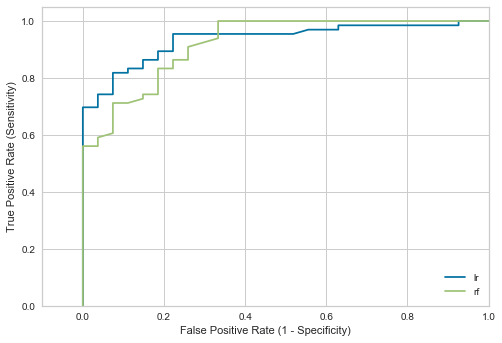

In [17]:
#generate lr model false positive and true positive rates
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, predicted_probs_lr[:,1])

#generate same for random forest model
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, predicted_probs_rf[:,1])

# plot LR and RF model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.xlim([-0.10, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


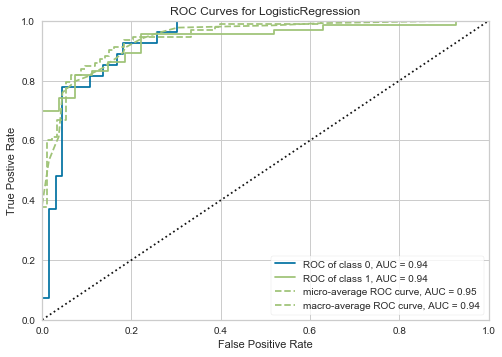

In [18]:
visualizer = ROCAUC(lr)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()

The ROC curve allows you to balance how many FN's (misses) and FP's (false alarms) you're willing to have with respect to one of your classes.

There's a metric that allows you to quantify the overall performance of your binary classifier, regardless of the threshold you choose. This metric is called the **AUC (area under the curve)**, and is a systematic way to compare two classifiers relative to each other, across all decision thresholds. If model A has a higher AUC than model B then this means that on average, model A is a better classifier across all decision thresholds (all probabilities). 

Besides allowing you to calculate AUC, seeing the ROC curve can help you to choose a threshold that **balances sensitivity and specificity** in a way that makes sense for the particular context.

In [19]:
# calculate AUC for lr and rf
print("LR model AUC: ",metrics.roc_auc_score(y_test, predicted_probs_lr[:,1]))
print("RF model AUC: ",metrics.roc_auc_score(y_test, predicted_probs_rf[:,1]))

LR model AUC:  0.9357463524130191
RF model AUC:  0.9214365881032548


Let's make this more explicit. Let's say instead of using 0.5 as the probability threshold for class 1, we want the probability threshold where the false positive rate is no higher than 12% (because additional false positives cost too much money, or time, etc.). 

Let's take a look at a graph of the ROC curve and the class 1 thresholds as a function of FPR:

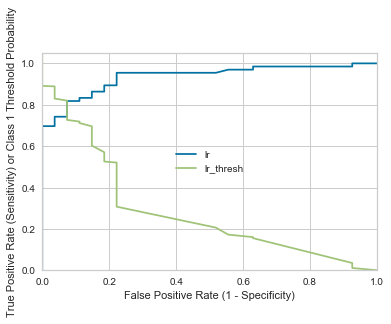

In [67]:
# plot LR and RF model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_lr,thresholds_lr, label="lr_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability')


It looks like the threshold that satisfies our criteria is ~0.7. Let's use this new threshold to generate our predictions and see what our new confusion matrix looks like:

In [20]:
y_test_lr_df["predicted_07"] = (y_test_lr_df.class_1 > 0.7).astype(float)
print(y_test_lr_df.head())
print("Confusion matrix at original 0.5 threshold:\n",metrics.confusion_matrix(y_test_lr_df.actual,
                                                                      y_test_lr_df.predicted),"\n")
print("Classification Report at original 0.5 threshold:\n", metrics.classification_report(y_test_lr_df.actual,
                                                                                          y_test_lr_df.predicted),"\n")
print("Confusion matrix at 0.7 threshold:\n",metrics.confusion_matrix(y_test_lr_df.actual,
                                                                      y_test_lr_df.predicted_07),"\n")
print("Classification Report at 0.7 threshold:\n", metrics.classification_report(y_test_lr_df.actual,
                                                                                 y_test_lr_df.predicted_07))

   class_0  class_1  predicted  actual  predicted_07
0    0.018    0.982        1.0     1.0           1.0
1    0.111    0.889        1.0     0.0           1.0
2    0.011    0.989        1.0     1.0           1.0
3    0.094    0.906        1.0     1.0           1.0
4    0.010    0.990        1.0     1.0           1.0
Confusion matrix at original 0.5 threshold:
 [[21  6]
 [ 6 60]] 

Classification Report at original 0.5 threshold:
               precision    recall  f1-score   support

         0.0       0.78      0.78      0.78        27
         1.0       0.91      0.91      0.91        66

   micro avg       0.87      0.87      0.87        93
   macro avg       0.84      0.84      0.84        93
weighted avg       0.87      0.87      0.87        93
 

Confusion matrix at 0.7 threshold:
 [[24  3]
 [11 55]] 

Classification Report at 0.7 threshold:
               precision    recall  f1-score   support

         0.0       0.69      0.89      0.77        27
         1.0       0.95      0

### Sk-learn documentation for output of the Classification Report

The *precision* is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The *recall* is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The *F-beta score* can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The *support* is the number of occurrences of each class in y_true.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support
    
The reported averages include *micro average* (averaging the total true positives, false negatives and false positives), *macro average* (averaging the unweighted mean per label), *weighted average* (averaging the support-weighted mean per label) and *sample average* (only for multilabel classification)

As a result, we've now increased our precision for class 1 (we are more certain someone has a back problem, when our classifier says you have a back problem), but have also lowered our recall for class 1 (now, more people with back problems will go un-identified by our classifier). The opposite occurs for precision and recall for class 0 as a result.

**So, depending on what you want to maximize or minimize for your machine learning application, your decision threshold for your (completely trained) classifier will differ.**

**One final important point about computing the AUC, you have to use the predicted probabilities, not the class labels themselves when computing an ROC curve or AUC.**

If you use y_pred_class, it will not give you an error, rather it will interpret the ones and zeros as predicted probabilities of 100% and 0%, and thus will give you incorrect results:

In [21]:
# calculate AUC using y_pred_class (producing incorrect results)
print("Wrong way to calculate LR model AUC: ",metrics.roc_auc_score(y_test, predictions_lr))
print("Wrong way to calculate RF model AUC: ",metrics.roc_auc_score(y_test, predictions_rf))

Wrong way to calculate LR model AUC:  0.8434343434343434
Wrong way to calculate RF model AUC:  0.8173400673400674


As a final way to compare the two models, let's see if we can look at each of their predicted probabilites on the test set as a function of the actual category (the target):

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002278202AA90>,
      dtype=object)

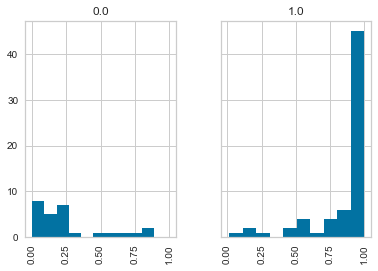

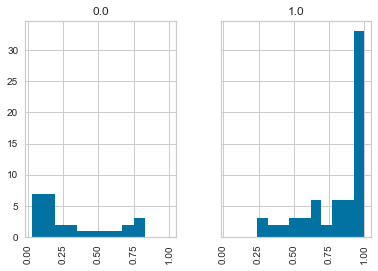

In [70]:
# histogram of predicted probabilities grouped by actual response value for LR
y_test_lr_df.class_1.hist(by= y_test_lr_df.actual, sharex=True, sharey=True)
#same for RF
y_test_rf_df.class_1.hist(by= y_test_rf_df.actual, sharex=True, sharey=True)

Depending on what threshold we choose will affect what part of each histogram consists of misclassified examples.

Nonetheless, it is fruitful at this point to examine all of those test-set samples that each classifier was "very certain" about (had very high or very low probability) but was of the wrong category (a class 0 sample that had a very high probability or a class 1 sample with a probability very close to 0).

### All that matters for ROC/AUC is the order of the probabilities, not their values

Let's go through our vertebral data example from start to finish to demonstrate a very important point:

In [22]:
#load in data
vertebral_data = pd.read_csv("data/vertebral_column_2_categories.dat",sep=" ", 
                             names=["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle", 
                                    "sacral_slope","pelvic_radius","spondy_grade","outcome"])
                                    

#convert outcome into binary 0/1 attribute
le = LabelEncoder()
# use fit_transform on LabelEncoder object
vertebral_data.outcome = le.fit_transform(vertebral_data.outcome)
# Define X and y data
X = vertebral_data[vertebral_data.columns.tolist()[:-1]]
y = vertebral_data.outcome

#create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)
#create logistic regression object
lr = LogisticRegression()
# fit the logisticRegression model
lr.fit(X_train,y_train)
# use the fitted model to predict
y_test_pred = lr.predict(X_test)

print("Test set accuracy of default 0.5 threshold LR model: ",metrics.accuracy_score(y_test, y_test_pred))

Test set accuracy of default 0.5 threshold LR model:  0.8602150537634409


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([39.,  8.,  5.,  7.,  4.,  5.,  5.,  7., 11.,  2.]),
 array([6.81179706e-10, 9.89455648e-02, 1.97891129e-01, 2.96836693e-01,
        3.95782257e-01, 4.94727821e-01, 5.93673385e-01, 6.92618950e-01,
        7.91564514e-01, 8.90510078e-01, 9.89455642e-01]),
 <a list of 10 Patch objects>)

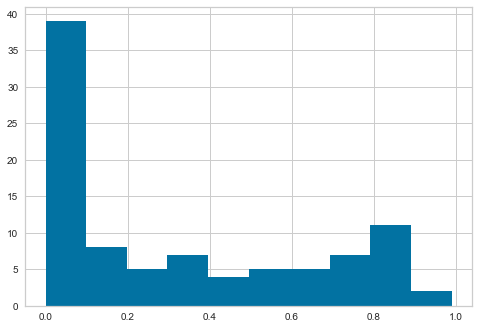

In [24]:
# calculate predicted probabilities for class 1
y_pred_prob1 = lr.predict_proba(X_test)[:, 1]
# show predicted probabilities in a histogram
plt.hist(y_pred_prob1)

In [23]:
# calculate AUC
metrics.___________(_________, __________)

0.9483726150392817

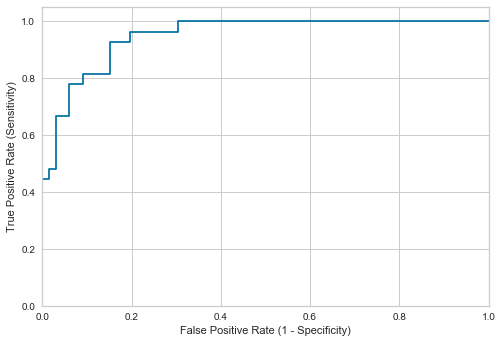

In [33]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob1)
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

### First Demonstration: Take the square root of predicted probabilities (makes them all bigger, but preserve the order of probabilities)

In [26]:
# change the predicted probabilities
y_pred_prob2 = np.sqrt(y_pred_prob1)

In [27]:
# here are the old ones (y_pred_prob1)
print("Old predicted probs:\n",y_pred_prob1[:10].round(3))

Old predicted probs:
 [0.036 0.19  0.004 0.038 0.013 0.143 0.86  0.001 0.    0.83 ]


In [28]:
# here are the new ones (y_pred_prob2)
print("New predicted probs:\n",y_pred_prob2[:10].round(3))

New predicted probs:
 [0.19  0.436 0.063 0.194 0.114 0.379 0.927 0.036 0.013 0.911]


(array([23., 12.,  4.,  7.,  2.,  6.,  9.,  7., 10., 13.]),
 array([2.60994197e-05, 9.94948744e-02, 1.98963649e-01, 2.98432424e-01,
        3.97901199e-01, 4.97369974e-01, 5.96838749e-01, 6.96307524e-01,
        7.95776299e-01, 8.95245074e-01, 9.94713849e-01]),
 <a list of 10 Patch objects>)

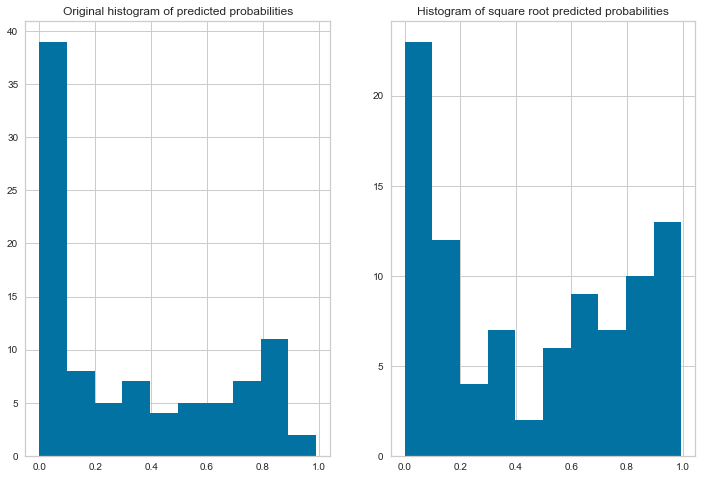

In [29]:
# you can see the histogram changed
figure = plt.figure(figsize=(12,8))
figure.add_subplot(121)
plt.title("Original histogram of predicted probabilities")
plt.hist(y_pred_prob1)
figure.add_subplot(122)
plt.title("Histogram of square root predicted probabilities")
plt.hist(y_pred_prob2)

In [30]:
# the AUC did not change
print("Old AUC: ",metrics.roc_auc_score(y_test, y_pred_prob1))
print("New AUC: ",metrics.roc_auc_score(y_test, y_pred_prob2))

Old AUC:  0.9483726150392817
New AUC:  0.9483726150392817


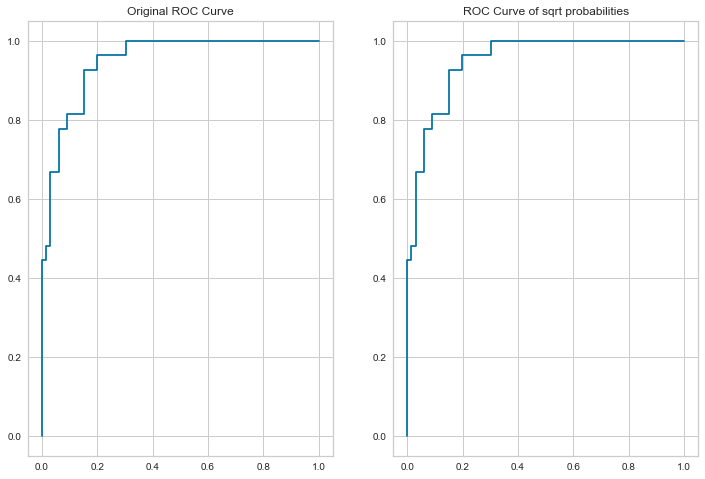

In [34]:
# the ROC curve did not change
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_pred_prob2)
figure = plt.figure(figsize=(12,8))
figure.add_subplot(121)
plt.plot(fpr, tpr)
plt.title("Original ROC Curve")
figure.add_subplot(122)
plt.title("ROC Curve of sqrt probabilities")
plt.plot(fpr2, tpr2)

#### Make small predicted probabilities smaller, and make big predicted probabilities bigger

In [35]:
y_pred_prob3 = np.where(y_pred_prob1 > 0.5, np.sqrt(y_pred_prob1), y_pred_prob1**2)
# you can see these are different from y_pred_prob1 and y_pred_prob2
y_pred_prob3[:10]

array([1.31141148e-03, 3.61814010e-02, 1.58115860e-05, 1.42379480e-03,
       1.71623907e-04, 2.05439964e-02, 9.27156880e-01, 1.60516312e-06,
       2.71821138e-08, 9.10838449e-01])

(array([53., 10.,  0.,  0.,  0.,  0.,  0.,  7., 10., 13.]),
 array([4.64005792e-19, 9.94713849e-02, 1.98942770e-01, 2.98414155e-01,
        3.97885540e-01, 4.97356925e-01, 5.96828310e-01, 6.96299694e-01,
        7.95771079e-01, 8.95242464e-01, 9.94713849e-01]),
 <a list of 10 Patch objects>)

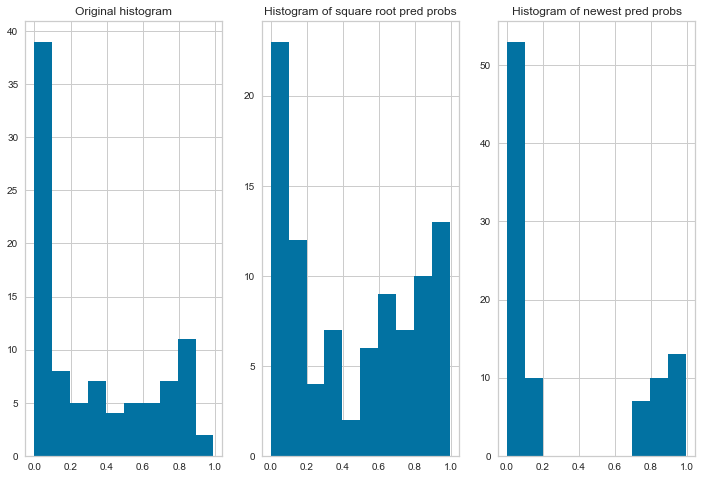

In [36]:
# the histogram changed
# you can see the histogram changed
figure = plt.figure(figsize=(12,8))
figure.add_subplot(131)
plt.title("Original histogram")
plt.hist(y_pred_prob1)
figure.add_subplot(132)
plt.title("Histogram of square root pred probs")
plt.hist(y_pred_prob2)
figure.add_subplot(133)
plt.title("Histogram of newest pred probs")
plt.hist(y_pred_prob3)

In [37]:
# the AUC did not change
print("Original AUC: ",metrics.roc_auc_score(y_test, y_pred_prob1))
print("Square root probs AUC: ",metrics.roc_auc_score(y_test, y_pred_prob2))
print("Newest transformed AUC: ",metrics.roc_auc_score(y_test, y_pred_prob3))

Original AUC:  0.9483726150392817
Square root probs AUC:  0.9483726150392817
Newest transformed AUC:  0.9483726150392817


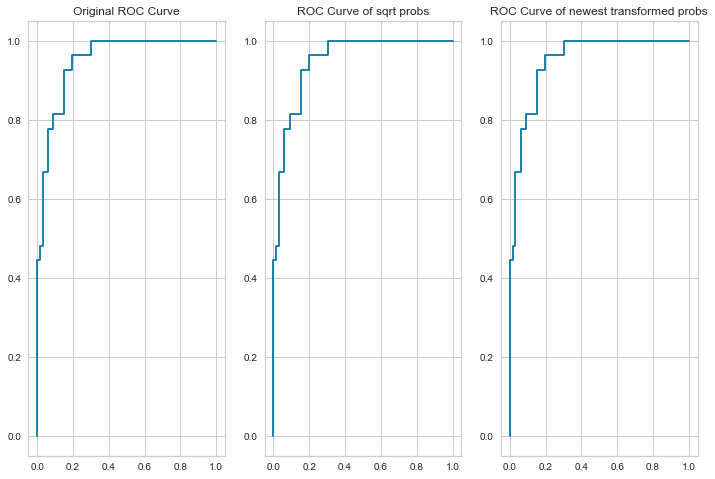

In [38]:
fpr3, tpr3, thresholds2 = metrics.roc_curve(y_test, y_pred_prob3)
# the ROC curve did not change
figure = plt.figure(figsize=(12,8))
figure.add_subplot(131)
plt.plot(fpr, tpr)
plt.title("Original ROC Curve")
figure.add_subplot(132)
plt.title("ROC Curve of sqrt probs")
plt.plot(fpr2, tpr2)
figure.add_subplot(133)
plt.title("ROC Curve of newest transformed probs")
plt.plot(fpr3, tpr3)

The point of all of this is, as long as the ordering of probabilities for all of your samples is maintained, the ROC will remain identical.

All that matters is the order of the predicted probabilities in predicted data, not the actual values!

### ROC/Confusion Matrix/Metric Takeaways

* For binary classifiers, you want to have the highest AUC possible. To decide between two classifiers, maximize the one that has the higher AUC.
* Once you've maximized your AUC, you set about choosing your classifier threshold based on the specifics of your problem. If you need to minimize false alarms (so maximize precision) while keeping your recall some acceptable level, then you do one thing. If you need to maximize accuracy, you do something else.
* In every case, what you're doing is generating a threshold from a specific point on the ROC curve.